<a href="https://colab.research.google.com/github/noambassat/Colorectal_Histology_Classifier/blob/main/8_JONATAN_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from imblearn.under_sampling import RandomUnderSampler


In [2]:
file_path = "final_sample_df.xlsx"

In [3]:
data = pd.read_excel(file_path)

# EDA


In [5]:
data.columns

Index(['מספר תיק', 'מספר הליך', 'Year', 'מדינת ישראל בצד א'', 'גוף המסמך חתוך',
       'גוף המסמך חתוך למסווג השני', 'גוף המסמך חתוך - embeddings',
       'גוף המסמך חתוך למסווג השני - embeddings',
       'first_classifier_predicted_probability',
       'first_classifier_original_prediction',
       'first_classifier_treshold_prediction',
       'second_classifier_predicted_probability',
       'second_classifier_original_prediction',
       'second_classifier_treshold_prediction', 'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד'],
      dtype='object')

In [6]:
data.columns

Index(['מספר תיק', 'מספר הליך', 'Year', 'מדינת ישראל בצד א'', 'גוף המסמך חתוך',
       'גוף המסמך חתוך למסווג השני', 'גוף המסמך חתוך - embeddings',
       'גוף המסמך חתוך למסווג השני - embeddings',
       'first_classifier_predicted_probability',
       'first_classifier_original_prediction',
       'first_classifier_treshold_prediction',
       'second_classifier_predicted_probability',
       'second_classifier_original_prediction',
       'second_classifier_treshold_prediction', 'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד'],
      dtype='object')

In [7]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

0

מחיקה של מה שהוא בקשה אחרת או דלמטה מיוחד

In [8]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [9]:
check_data = data[[
       'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?']]

In [10]:
check_data[check_data['בקשה לרשות ערעור התקבלה?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
25,None,התקבל
26,None,חלקי
31,None,חלקי
34,None,חלקי
44,None,התקבל
...,...,...
406,None,חלקי
414,None,נדחה
419,None,חלקי
433,None,None


In [11]:
check_data[check_data[ 'הערעור התקבל?'].isnull()]

,בקשה לרשות ערעור התקבלה?,הערעור התקבל?
2,חלקי,None
4,אחר,None
8,אחר,None
14,חלקי,None
17,חלקי,None
...,...,...
428,נדחה,None
433,None,None
436,התקבל,None
441,התקבל,None


\אם הערך ריק ב"בקשה לרשות הערעור" - סימן שהתיק הזה לא נבדק.

In [12]:
clean_data = data.dropna(subset = ['בקשה לרשות ערעור התקבלה?'])

In [13]:
 clean_data['בקשה לרשות ערעור התקבלה?'].unique()

array(['חלקי', 'אחר', 'נדחה', 'התקבל'], dtype=object)

In [14]:
clean_data["second_classifier_treshold_prediction"].unique()

array([ 0.,  1., nan])

אנחנו מתעלמים מכל מה שהבקשה שלו מסווגת כ"אחר"

In [15]:
clean_data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [16]:
clean_data.shape

(349, 17)

In [17]:
clean_data = data.dropna(subset=["בקשה לרשות ערעור התקבלה?"])

In [18]:
clean_data.shape

(377, 17)

אנו מסווגים את כל מה שחלקי\התקבל כ1, ומה שנדחה כ0.

In [19]:
clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-19-c8b97bc14048>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['binary_outcome_for_first_classifier'] = clean_data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [20]:
clean_data['binary_outcome_for_first_classifier'].value_counts()

,count
binary_outcome_for_first_classifier,
1,291
0,86


In [21]:

def create_CM(data, labeled_col, predicted_col):
    # יצירת confusion matrix
    cm = confusion_matrix(data[labeled_col], data[predicted_col])

    # הצגת תוצאות confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # ויזואליזציה של confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    if labeled_col.find("threshold") != -1:
        plt.title("Confusion Matrix for Threshold")
    plt.show()

    # חישוב Accuracy ו-F1 Score
    accuracy = accuracy_score(data[labeled_col], data[predicted_col])
    f1 = f1_score(data[labeled_col], data[predicted_col])

    # הצגת Accuracy ו-F1 Score
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")



## First classifier

Confusion Matrix:
[[ 40 148]
 [ 46 143]]


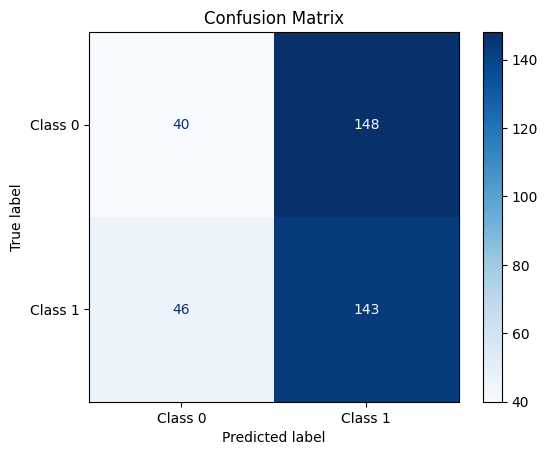

Accuracy: 0.49
F1 Score: 0.60


In [22]:
create_CM(clean_data,"first_classifier_treshold_prediction",'binary_outcome_for_first_classifier')
# בדיקה עבור ערכים עם סף סיווג = 0.67

Confusion Matrix:
[[ 39 145]
 [ 47 146]]


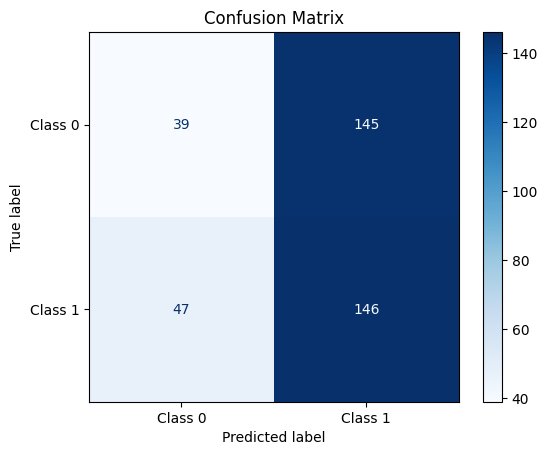

Accuracy: 0.49
F1 Score: 0.60


In [23]:
create_CM(clean_data,"first_classifier_original_prediction",'binary_outcome_for_first_classifier')
# בדיקת הערכים ללא סף הסיווג (דיפולטי 0.5)

# מסווג שני

In [24]:
[["מספר תיק", "מספר הליך","Year","מדינת ישראל בצד א'",
    'גוף המסמך חתוך', 'גוף המסמך חתוך למסווג השני',
       'גוף המסמך חתוך - embeddings',
       'גוף המסמך חתוך למסווג השני - embeddings',
       'first_classifier_predicted_probability',
       'first_classifier_original_prediction',
       'first_classifier_treshold_prediction',
       'second_classifier_predicted_probability',
       'second_classifier_original_prediction',
       'second_classifier_treshold_prediction']
]

[['מספר תיק',
  'מספר הליך',
  'Year',
  "מדינת ישראל בצד א'",
  'גוף המסמך חתוך',
  'גוף המסמך חתוך למסווג השני',
  'גוף המסמך חתוך - embeddings',
  'גוף המסמך חתוך למסווג השני - embeddings',
  'first_classifier_predicted_probability',
  'first_classifier_original_prediction',
  'first_classifier_treshold_prediction',
  'second_classifier_predicted_probability',
  'second_classifier_original_prediction',
  'second_classifier_treshold_prediction']]

In [25]:
check_data = clean_data.dropna(subset=["הערעור התקבל?"])
check_data[check_data["second_classifier_treshold_prediction"].isna()]

,מספר תיק,מספר הליך,Year,מדינת ישראל בצד א',גוף המסמך חתוך,גוף המסמך חתוך למסווג השני,גוף המסמך חתוך - embeddings,גוף המסמך חתוך למסווג השני - embeddings,first_classifier_predicted_probability,first_classifier_original_prediction,first_classifier_treshold_prediction,second_classifier_predicted_probability,second_classifier_original_prediction,second_classifier_treshold_prediction,בקשה לרשות ערעור התקבלה?,הערעור התקבל?,"רע""פ בקשה אחרת או דלמטה מיוחד",binary_outcome_for_first_classifier
5,248/00,"רע""פ 248/00",2000,0,"ת את המתלוננת בתשלום סך של 10,000 ש""ח. בית המש...",של 3 חודשים בחופף למאסר שהוטל עליו בגין אותה ...,[ 1.17203236e-01 1.84556246e-01 -1.35313943e-...,NaN,0.159516,0,0,NaN,NaN,NaN,נדחה,חלקי,NaN,0
6,9575/00,"רע""פ 9575/00",2000,0,"[' בבית המשפט העליון רע""פ 9575/00 - א\' בפני: ...","[' בבית המשפט העליון רע""פ 9575/00 - א\' בפני: ...",[ 4.22527373e-01 3.01872224e-01 -2.89317608e-...,NaN,0.633548,1,0,NaN,NaN,NaN,התקבל,חלקי,NaN,1
7,8488/00,"רע""פ 8488/00",2000,0,"ל טענותיוהעובדתיות והמשפטיות של העותר, וככזו א...",בהחילו הלכה קיימת ומבוססת הנוגעת לתנאיםשבהתקיי...,[ 1.85594648e-01 -1.32016584e-01 -4.52096224e-...,NaN,0.005354,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
27,623/03,"רע""פ 623/03",2003,0,להישפט בגין קנסות מנהליים? לאחרשעיינתי בפסק די...,"ני, בגדרה שבה המבקשתומצביעה על השאלה המשפטית, ...",[ 2.51965404e-01 -1.43055012e-02 -4.16686624e-...,NaN,0.003970,0,0,NaN,NaN,NaN,אחר,חלקי,NaN,1
29,7878/03,"רע""פ 7878/03",2003,0,"טה עיינובבקשה, בפסקי הדין של ערכאות קמא ובתסקי...","עמית תאריך הישיבה: כ""א בטבתתשס""ד (15.1.2004)ב...",[ 2.93724597e-01 -1.83445532e-02 -3.29123467e-...,NaN,0.217591,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,7505/21,"רע""פ 7505/21",2021,0,"סעיף 8 לחוק הפלת""ד חוסם את דרכו של נפגע בתאונת...","הפלת""ד אינה מייתרת את הסמכות הנתונה לבית המשפט...",[ 3.48626256e-01 -2.60763377e-01 -4.69315380e-...,NaN,0.016171,0,0,NaN,NaN,NaN,אחר,נדחה,NaN,1
435,172/21,"רע""פ 172/21",2021,0,המחוזי הפך את התוצאה אליה הגיע בית משפט השלום...,להכיל את מעשיו החמורים של המבקש. 10. בטרם אסיי...,[ 4.98750210e-01 -2.43861571e-01 -4.87517357e-...,NaN,0.002501,0,0,NaN,NaN,NaN,חלקי,התקבל,NaN,1
442,7941/22,"רע""פ 7941/22",2022,0,"כנית של הממונה על עבודות השירות. על כן, בהינתן...","ה 24 (8.2.2022)). בנסיבות ענייננו, מאחר וערעור...",[ 3.59173506e-01 -1.17397860e-01 -5.06801605e-...,NaN,0.095935,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
444,4197/22,"רע""פ 4197/22",2022,0,"(15.06.2022)). בענייננו, המבקש לא הצביע על עיל...","(21.06.2022); רע""פ 3871/22 יונקץ נ\' מדינת ישר...",[ 3.59634429e-01 -1.20472185e-01 -4.68034446e-...,NaN,0.001482,0,0,NaN,NaN,NaN,חלקי,התקבל,NaN,1


In [26]:
check_data['הערעור התקבל?'].unique()

array(['חלקי', 'אחר', 'נדחה', 'התקבל'], dtype=object)

In [27]:
check_data[check_data['הערעור התקבל?']=="אחר"]

,מספר תיק,מספר הליך,Year,מדינת ישראל בצד א',גוף המסמך חתוך,גוף המסמך חתוך למסווג השני,גוף המסמך חתוך - embeddings,גוף המסמך חתוך למסווג השני - embeddings,first_classifier_predicted_probability,first_classifier_original_prediction,first_classifier_treshold_prediction,second_classifier_predicted_probability,second_classifier_original_prediction,second_classifier_treshold_prediction,בקשה לרשות ערעור התקבלה?,הערעור התקבל?,"רע""פ בקשה אחרת או דלמטה מיוחד",binary_outcome_for_first_classifier
1,4125/00,"רע""פ 4125/00",2000,0,"[' בבית המשפט העליון בירושלים רע""פ 4125/00 - ג...","[' בבית המשפט העליון בירושלים רע""פ 4125/00 - ג...",[ 3.08246166e-01 1.56057060e-01 -3.61327618e-...,[ 3.49724978e-01 1.46459669e-01 -3.36104900e-...,0.783831,1,1,0.021727,0.0,0.0,אחר,אחר,NaN,1
3,3202/00,"רע""פ 3202/00",2000,0,"ביב-יפו מיום 14.3.00 בע""פ 1113/97 שניתן על ידי...",מי טולדו 5.שמואל ברלוביץ נגד המשיבה: מדינת ישר...,[ 3.16370577e-01 2.19854087e-01 -4.68060642e-...,[ 3.09484929e-01 2.62777328e-01 -3.02062124e-...,0.989982,1,1,0.951715,1.0,1.0,אחר,אחר,NaN,1
7,8488/00,"רע""פ 8488/00",2000,0,"ל טענותיוהעובדתיות והמשפטיות של העותר, וככזו א...",בהחילו הלכה קיימת ומבוססת הנוגעת לתנאיםשבהתקיי...,[ 1.85594648e-01 -1.32016584e-01 -4.52096224e-...,NaN,0.005354,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
29,7878/03,"רע""פ 7878/03",2003,0,"טה עיינובבקשה, בפסקי הדין של ערכאות קמא ובתסקי...","עמית תאריך הישיבה: כ""א בטבתתשס""ד (15.1.2004)ב...",[ 2.93724597e-01 -1.83445532e-02 -3.29123467e-...,NaN,0.217591,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
32,10272/03,"רע""פ 10272/03",2003,0,"['החלטה בתיק רע""פ 10272/03 בבית המשפט העליון ר...","['החלטה בתיק רע""פ 10272/03 בבית המשפט העליון ר...",[ 3.67580265e-01 -2.22027525e-01 -4.45714563e-...,NaN,0.122553,0,0,NaN,NaN,NaN,חלקי,אחר,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,310/18,"רע""פ 310/18",2018,0,"יצוי בדרך של עבודות שירות, אשר הושת על המבקש. ...","ות הערעור נדחית בזאת, וכפועל יוצא מכך מתבטלת ה...",[ 4.56867069e-01 -6.87179789e-02 -4.52374041e-...,[ 3.78170162e-01 2.68727057e-02 -3.15362722e-...,0.700880,1,1,0.448502,0.0,0.0,אחר,אחר,NaN,1
412,678/18,"רע""פ 678/18",2018,0,של המבקש מתייחסות לקביעות מהימנות ולשאלות שבע...,"התרשל בנהיגתו, מעוגנת היטב בנתונים העובדתיים ...",[ 4.37705934e-01 -6.84608668e-02 -5.60097218e-...,NaN,0.119160,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
430,9177/20,"רע""פ 9177/20",2020,0,ך המשמעותית שעבר המבקש מעת ביצוע העבירה ועד לע...,"ת דין, ודאי שלא כאשר לא הוכח כי הדבר יביא לפגי...",[ 5.25736272e-01 -2.19081596e-01 -5.86645246e-...,NaN,0.022526,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1
442,7941/22,"רע""פ 7941/22",2022,0,"כנית של הממונה על עבודות השירות. על כן, בהינתן...","ה 24 (8.2.2022)). בנסיבות ענייננו, מאחר וערעור...",[ 3.59173506e-01 -1.17397860e-01 -5.06801605e-...,NaN,0.095935,0,0,NaN,NaN,NaN,התקבל,אחר,NaN,1


In [28]:
check_data = check_data[check_data['הערעור התקבל?']!="אחר"]

In [29]:
check_data['הערעור התקבל?'].unique()

array(['חלקי', 'נדחה', 'התקבל'], dtype=object)

In [30]:
check_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)

<ipython-input-30-f7b8d880d0b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data['binary_outcome_for_second_classifier'] = clean_data['הערעור התקבל?'].apply(lambda x: 0 if x == 'נדחה' else 1)


In [31]:
check_data.dropna(subset=["second_classifier_treshold_prediction"],inplace = True)

<ipython-input-31-e72039ed3794>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data.dropna(subset=["second_classifier_treshold_prediction"],inplace = True)


Confusion Matrix:
[[22 38]
 [18 39]]


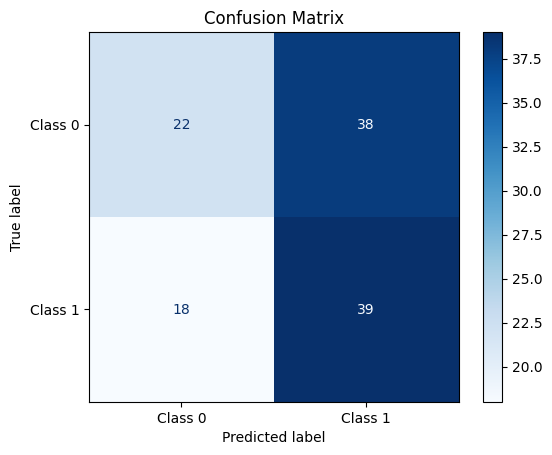

Accuracy: 0.52
F1 Score: 0.58


In [32]:
create_CM(check_data,'second_classifier_treshold_prediction','binary_outcome_for_second_classifier')
# עבור סף סיווג של 0.9

Confusion Matrix:
[[14 21]
 [26 56]]


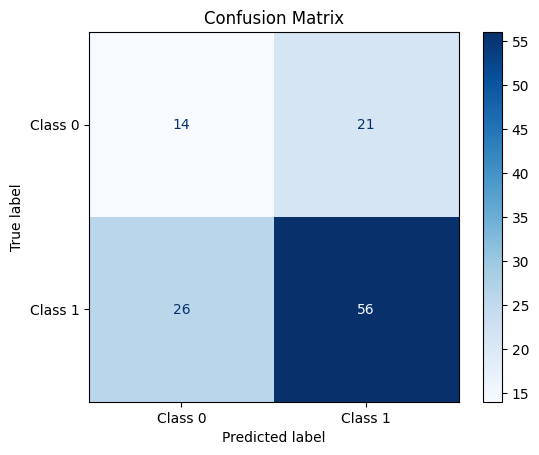

Accuracy: 0.60
F1 Score: 0.70


In [33]:
create_CM(check_data,"second_classifier_original_prediction",'binary_outcome_for_second_classifier')
# עבור סף סיווג דיפלוטי